In [3]:
# IF NOT LAUNCHING WITH GOOGLE COLAB, SET THIS TO FALSE
using_colab = True

In [4]:
# setup for colab
if using_colab:
    # connect google drive to colab
    from google.colab import drive
    drive.mount('/content/gdrive', force_remount=True)
    
    # download packages to google colab
    !pip install matplotlib
    !pip install numpy
    !pip install pandas
    !pip install sklearn
    !pip install xgboost


# to clean output of cell
from IPython.display import clear_output
clear_output()

In [5]:
# import packages
import time
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import warnings

In [6]:
def load_data(data_path):
    data = np.load(data_path, allow_pickle=True)

    X_train = data['X_train']
    X_test = data['X_test']
    y_train = data['y_train']
    y_test = data['y_test']

    return X_train, X_test, y_train, y_test

In [7]:
def get_sample_data(data, nb_samples):
    X_train, X_test, y_train, y_test = data

    # for multi-dimensional arrays
    X_train = X_train[:nb_samples,:]
    X_test = X_test[:nb_samples,:]

    # for 1 dimensional arrays
    y_train = y_train[:nb_samples]
    y_test = y_test[:nb_samples]

    return X_train, X_test, y_train, y_test

In [8]:
def train_save_model(model, parameters_grid, dataset_name, root_dir, test_mode=False):

    # get data
    data_path = root_dir + '/data/' + dataset_name + '_train_test_sets' + '.npz'
    data = load_data(data_path)

    test_mode_samples = 10000
    if test_mode:
        # limit data points for faster execution time
        data = get_sample_data(data, test_mode_samples)
    else:
        # Suppress warnings for clean execution
        warnings.filterwarnings('ignore')
    
    X_train, X_test, y_train, y_test = data


    # normalization
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()

    # model pipeline
    from sklearn.pipeline import make_pipeline
    model_pipeline = make_pipeline(scaler, model)


    # cross validation setup
    nb_folds = 5
    from sklearn.model_selection import StratifiedKFold
    skfolds=StratifiedKFold(n_splits=nb_folds)

    # scoring metric for grid search
    from sklearn.metrics import make_scorer, roc_auc_score
    scorer = make_scorer(roc_auc_score)

    # final pipeline
    from sklearn.model_selection import GridSearchCV
    classifier = GridSearchCV(model_pipeline, 
                            param_grid=parameters_grid, 
                            cv=skfolds, 
                            scoring=scorer)


    if test_mode:
        # for knowing which parameters can be used in grid search
        print('\nPossible parameters:\n', classifier.estimator.get_params().keys(), '\n')
    

    # train the model
    start = time.time()
    classifier.fit(X_train, y_train)
    training_time = time.time() - start
    print('\nResult of grid search:\n')
    print('training time (s):', round(training_time))
    print('best parameters:', classifier.best_params_)
    print('AUROC on train set:', classifier.best_score_)
    print('\n')


    # save the model with pickle
    now = datetime.datetime.now()
    day_hour_min = str(now.day) + '-' + str(now.hour) + '-' + str(now.minute)
    model_save_name = type(model).__name__ + '-' + day_hour_min

    if not test_mode:
        model_save_path = root_dir + '/models/' + model_save_name + '.pkl'
        with open(model_save_path, 'wb') as f:
            pickle.dump(classifier, f)


    # get predictions of trained model on test set
    y_pred = classifier.predict(X_test)
    y_proba = np.delete(classifier.predict_proba(X_test), 0, axis=1)


    # AUROC score on test set
    from sklearn.metrics import roc_auc_score
    auroc = roc_auc_score(y_test, y_proba)
    print('AUROC on test set:', auroc, '\n')


    # confusion matrix on test set
    from sklearn.metrics import confusion_matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    TN, FP, FN, TP = conf_matrix.ravel()

    # confusion matrix graph
    from sklearn.metrics import ConfusionMatrixDisplay
    dist = ConfusionMatrixDisplay(conf_matrix, display_labels=['Repaid', 'Not repaid'])
    dist.plot()
    plt.show()


    # get average time for one prediction
    nb_iter = 100
    times = []
    for i in range(nb_iter):
        x = X_train[np.random.choice(X_train.shape[0])]
        x = np.reshape(x, (1, x.shape[0]))

        start = time.time()
        _ = classifier.predict(x)
        prediction_time = time.time() - start
        times.append(prediction_time)

    avg_predict_time_s = round(np.mean(times), 3)


    # load the models performance dataframe
    models_perf_path = root_dir + '/data/' + 'models_performance_3' + '.csv'
    models_perf = pd.read_csv(models_perf_path)
    original_shape = models_perf.shape

    # create new dataframe to store new perf
    current_models_perf = pd.DataFrame(columns=['model_type', 
                                                'AUROC_test_set', 
                                                'confusion_matrix_TN', 
                                                'confusion_matrix_FP', 
                                                'confusion_matrix_FN', 
                                                'confusion_matrix_TP', 
                                                'dataset_name', 
                                                'average_predict_time_s', 
                                                'model_save_name'])

    # put new perf in the new dataframe
    perf_list = [type(model).__name__, 
                 auroc, 
                 TN, 
                 FP, 
                 FN, 
                 TP, 
                 dataset_name, 
                 avg_predict_time_s, 
                 model_save_name]
    
    current_models_perf.loc[len(current_models_perf.index)] = perf_list

    # combine new dataframe to old one
    models_perf = models_perf.append(current_models_perf, ignore_index=True)


    if test_mode:
        # don't save the current model perf
        nb_rows_to_drop = current_models_perf.shape[0]
        rows_to_drop = np.arange(nb_rows_to_drop) + original_shape[0]
        models_perf = models_perf.drop(rows_to_drop, axis=0)
        print('\nno pb =', models_perf.shape == original_shape)

    # save combined dataframe
    models_perf.to_csv(models_perf_path, index=False)
    print('\nDone.')

In [9]:
# define root directory for the script
if using_colab:
    root_dir = '/content/gdrive/MyDrive/oc_projet_4'
else:
    root_dir = 'D:/OpenClassrooms/projet_4'

# define dataset to use
#dataset_name = 'app'
dataset_name = 'app_domain'
#dataset_name = 'app_poly'

## Now we try different models with different parameters
(These are the last ones which have been tested, I have tried multiple grid searchs on each model)


Result of grid search:

training time (s): 123
best parameters: {'dummyclassifier__strategy': 'most_frequent'}
AUROC on train set: 0.5


AUROC on test set: 0.5 



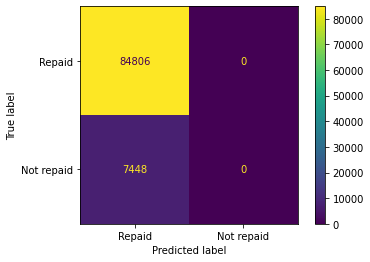


Done.


In [ ]:
# baseline: dummy classifier
from sklearn.dummy import DummyClassifier
model = DummyClassifier()

param_grid = {'dummyclassifier__strategy': ['most_frequent', 
                                            'prior', 
                                            'stratified', 
                                            'uniform', 
                                            'constant']}

train_save_model(model, param_grid, dataset_name, root_dir)


Result of grid search:

training time (s): 499
best parameters: {}
AUROC on train set: 0.6827870113678621


AUROC on test set: 0.7451632658507406 



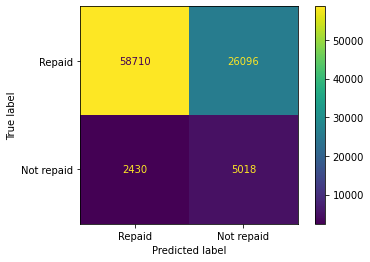


Done.


In [ ]:
# logistic regression
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(class_weight='balanced', penalty='none', max_iter=1000)

param_grid = {}

train_save_model(model, param_grid, dataset_name, root_dir)


Result of grid search:

training time (s): 3585
best parameters: {'sgdclassifier__alpha': 0.001, 'sgdclassifier__penalty': 'l1'}
AUROC on train set: 0.6819361635376534


AUROC on test set: 0.7454601144640653 



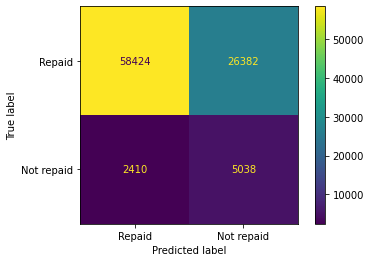


Done.


In [ ]:
# stochastic gradient descent
from sklearn.linear_model import SGDClassifier
model = SGDClassifier(class_weight='balanced', loss='log')

param_grid = {'sgdclassifier__penalty': ['l1', 'l2', 'elasticnet', 'none'], 
              'sgdclassifier__alpha': [0.01, 0.001, 0.0001]}

train_save_model(model, param_grid, dataset_name, root_dir)


Result of grid search:

training time (s): 5040
best parameters: {'sgdclassifier__loss': 'log', 'sgdclassifier__penalty': 'none'}
AUROC on train set: 0.6797145251241005


AUROC on test set: 0.7364222805810938 



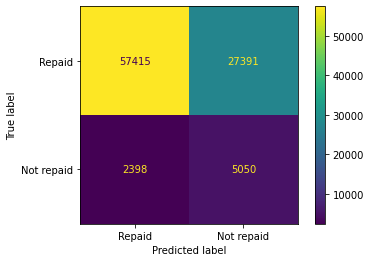


Done.


In [ ]:
# stochastic gradient descent
from sklearn.linear_model import SGDClassifier
model = SGDClassifier(class_weight='balanced')

param_grid = {'sgdclassifier__loss': ['log', 'modified_huber'], 
              'sgdclassifier__penalty': ['l1', 'l2', 'elasticnet', 'none']}

train_save_model(model, param_grid, dataset_name, root_dir)


Result of grid search:

training time (s): 1866
best parameters: {'randomforestclassifier__max_depth': 4, 'randomforestclassifier__n_estimators': 200}
AUROC on train set: 0.6587007387755448


AUROC on test set: 0.7138450381654542 



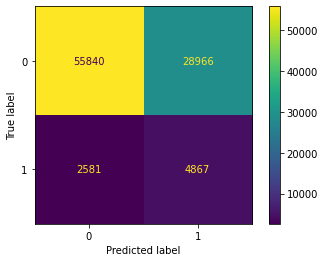


Done.


In [ ]:
# random forest
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(class_weight='balanced')
param_grid = {'randomforestclassifier__n_estimators': [50, 100, 200, 500], 
              'randomforestclassifier__max_depth': [2, 4]}

train_save_model(model, param_grid, dataset_name, root_dir)


Result of grid search:

training time (s): 82014
best parameters: {'xgbclassifier__max_depth': 6, 'xgbclassifier__n_estimators': 1500}
AUROC on train set: 0.5194626469198149


AUROC on test set: 0.7460079885555693 



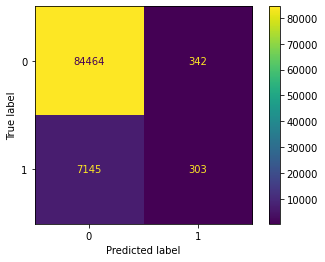


Done.


In [ ]:
# XGBoost
from xgboost import XGBClassifier
model = XGBClassifier(class_weight='balanced')

param_grid = {'xgbclassifier__n_estimators': [1000, 1500], 
              'xgbclassifier__max_depth': [6, 8]}

train_save_model(model, param_grid, dataset_name, root_dir)


Result of grid search:

training time (s): 7012
best parameters: {'gradientboostingclassifier__max_depth': 6, 'gradientboostingclassifier__n_estimators': 100}
AUROC on train set: 0.5346722436064036


AUROC on test set: 0.7027855401535261 



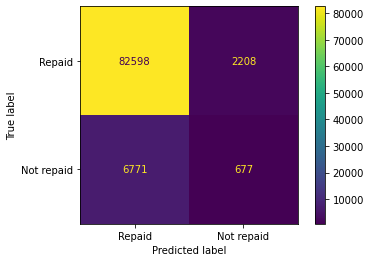


Done.


In [10]:
 # gradient boosting
from sklearn.ensemble import GradientBoostingClassifier
model = GradientBoostingClassifier(learning_rate=1)

param_grid = {'gradientboostingclassifier__n_estimators': [10, 100], 
              'gradientboostingclassifier__max_depth': [4, 6]}

train_save_model(model, param_grid, dataset_name, root_dir)